In [1]:
# Pre - requisit pip installations for this Assignment

# !pip install gymnasium
# !pip install "imageio[ffmpeg]"
# !pip install "gymnasium[box2d]"
# !pip install Box2D

In [2]:
import gymnasium as gym
import numpy as np
import random
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import imageio
import os
from collections import deque

In [3]:
# Hyperparameters

EPISODES = 1000
LEARNING_RATE = 1e-3
GAMMA = 0.99
EPS_START = 1.0
EPS_END = 0.01
EPS_DECAY = 0.995
BATCH_SIZE = 64
MEMORY_SIZE = 100_000
TARGET_UPDATE_FREQ = 10
MODEL_SAVE_FREQ = 100                           # Save model every 100 episodes

In [7]:
os.makedirs("saved_models", exist_ok=True)      # Create folder for saving models

In [8]:
# Q-Network
class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(QNetwork, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, action_dim)
        )

    def forward(self, x):
        return self.model(x)

# Replay Buffer
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        samples = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = map(np.array, zip(*samples))
        return states, actions, rewards, next_states, dones

    def __len__(self):
        return len(self.buffer)

# Epsilon-greedy action selection
def select_action(state, epsilon, q_net, action_dim):
    if random.random() < epsilon:
        return random.randint(0, action_dim - 1)
    else:
        with torch.no_grad():
            state = torch.FloatTensor(state).unsqueeze(0)
            return q_net(state).argmax().item()

In [9]:
# Training setup
env = gym.make("LunarLander-v3")

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

q_net = QNetwork(state_dim, action_dim)
target_net = QNetwork(state_dim, action_dim)
target_net.load_state_dict(q_net.state_dict())
target_net.eval()

optimizer = optim.Adam(q_net.parameters(), lr=LEARNING_RATE)
replay_buffer = ReplayBuffer(MEMORY_SIZE)

In [10]:
# Tracking metrics
rewards_per_episode = []
avg_losses = []
epsilon = EPS_START
epsilon_history = []

for episode in range(EPISODES):
    state, _ = env.reset()
    total_reward = 0
    losses = []

    done = False
    while not done:
        action = select_action(state, epsilon, q_net, action_dim)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        replay_buffer.push(state, action, reward, next_state, done)

        state = next_state
        total_reward += reward

        if len(replay_buffer) >= BATCH_SIZE:
            states, actions, rewards, next_states, dones = replay_buffer.sample(BATCH_SIZE)

            states = torch.FloatTensor(states)
            actions = torch.LongTensor(actions)
            rewards = torch.FloatTensor(rewards)
            next_states = torch.FloatTensor(next_states)
            dones = torch.FloatTensor(dones)

            q_values = q_net(states).gather(1, actions.unsqueeze(1)).squeeze(1)
            with torch.no_grad():
                next_q_values = target_net(next_states).max(1)[0]
                expected_q_values = rewards + GAMMA * next_q_values * (1 - dones)

            loss = nn.MSELoss()(q_values, expected_q_values)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            losses.append(loss.item())
            
    # Save model periodically
    if episode % MODEL_SAVE_FREQ == 0 and episode != 0:
        torch.save(q_net.state_dict(), f"saved_models/dqn_lunar_lander_episode{episode}.pth")
    
    # Update target network
    if episode % TARGET_UPDATE_FREQ == 0:
        target_net.load_state_dict(q_net.state_dict())

    # Tracking rewards and losses
    rewards_per_episode.append(total_reward)
    avg_losses.append(np.mean(losses) if losses else 0)
    epsilon = max(EPS_END, epsilon * EPS_DECAY)
    epsilon_history.append(epsilon)

    print(f"Episode {episode+1}, Reward: {total_reward:.2f}, Epsilon: {epsilon:.3f}, Loss: {avg_losses[-1]:.4f}")

    # Save final model at episode 1000
    torch.save(q_net.state_dict(), "saved_models/dqn_lunar_lander_episode1000.pth")

Episode 1, Reward: -96.59, Epsilon: 0.995, Loss: 6.6935
Episode 2, Reward: -200.02, Epsilon: 0.990, Loss: 59.7730
Episode 3, Reward: -66.61, Epsilon: 0.985, Loss: 92.5770
Episode 4, Reward: -491.07, Epsilon: 0.980, Loss: 83.8997
Episode 5, Reward: -107.74, Epsilon: 0.975, Loss: 70.9044
Episode 6, Reward: -199.93, Epsilon: 0.970, Loss: 72.4164
Episode 7, Reward: -241.69, Epsilon: 0.966, Loss: 65.0422
Episode 8, Reward: -159.67, Epsilon: 0.961, Loss: 57.3879
Episode 9, Reward: -184.48, Epsilon: 0.956, Loss: 61.0975
Episode 10, Reward: -126.29, Epsilon: 0.951, Loss: 48.8831
Episode 11, Reward: -225.86, Epsilon: 0.946, Loss: 59.3503
Episode 12, Reward: -89.47, Epsilon: 0.942, Loss: 45.9025
Episode 13, Reward: -283.97, Epsilon: 0.937, Loss: 38.2090
Episode 14, Reward: -460.96, Epsilon: 0.932, Loss: 50.7011
Episode 15, Reward: -473.22, Epsilon: 0.928, Loss: 52.7636
Episode 16, Reward: -97.05, Epsilon: 0.923, Loss: 37.1006
Episode 17, Reward: -273.75, Epsilon: 0.918, Loss: 48.9857
Episode 18,

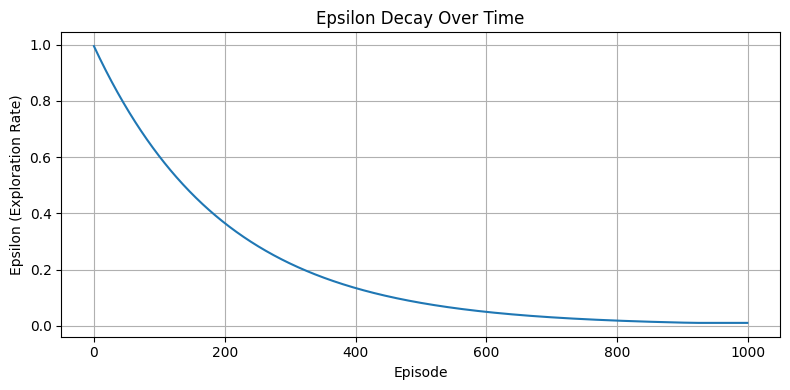

In [11]:
os.makedirs("figures", exist_ok=True)

# plot the epsilon decay curve

plt.figure(figsize=(8, 4))
plt.plot(epsilon_history)
plt.xlabel("Episode")
plt.ylabel("Epsilon (Exploration Rate)")
plt.title("Epsilon Decay Over Time")
plt.grid(True)
plt.tight_layout()
plt.savefig("figures/epsilon_decay.png")  # save the plot
plt.show()

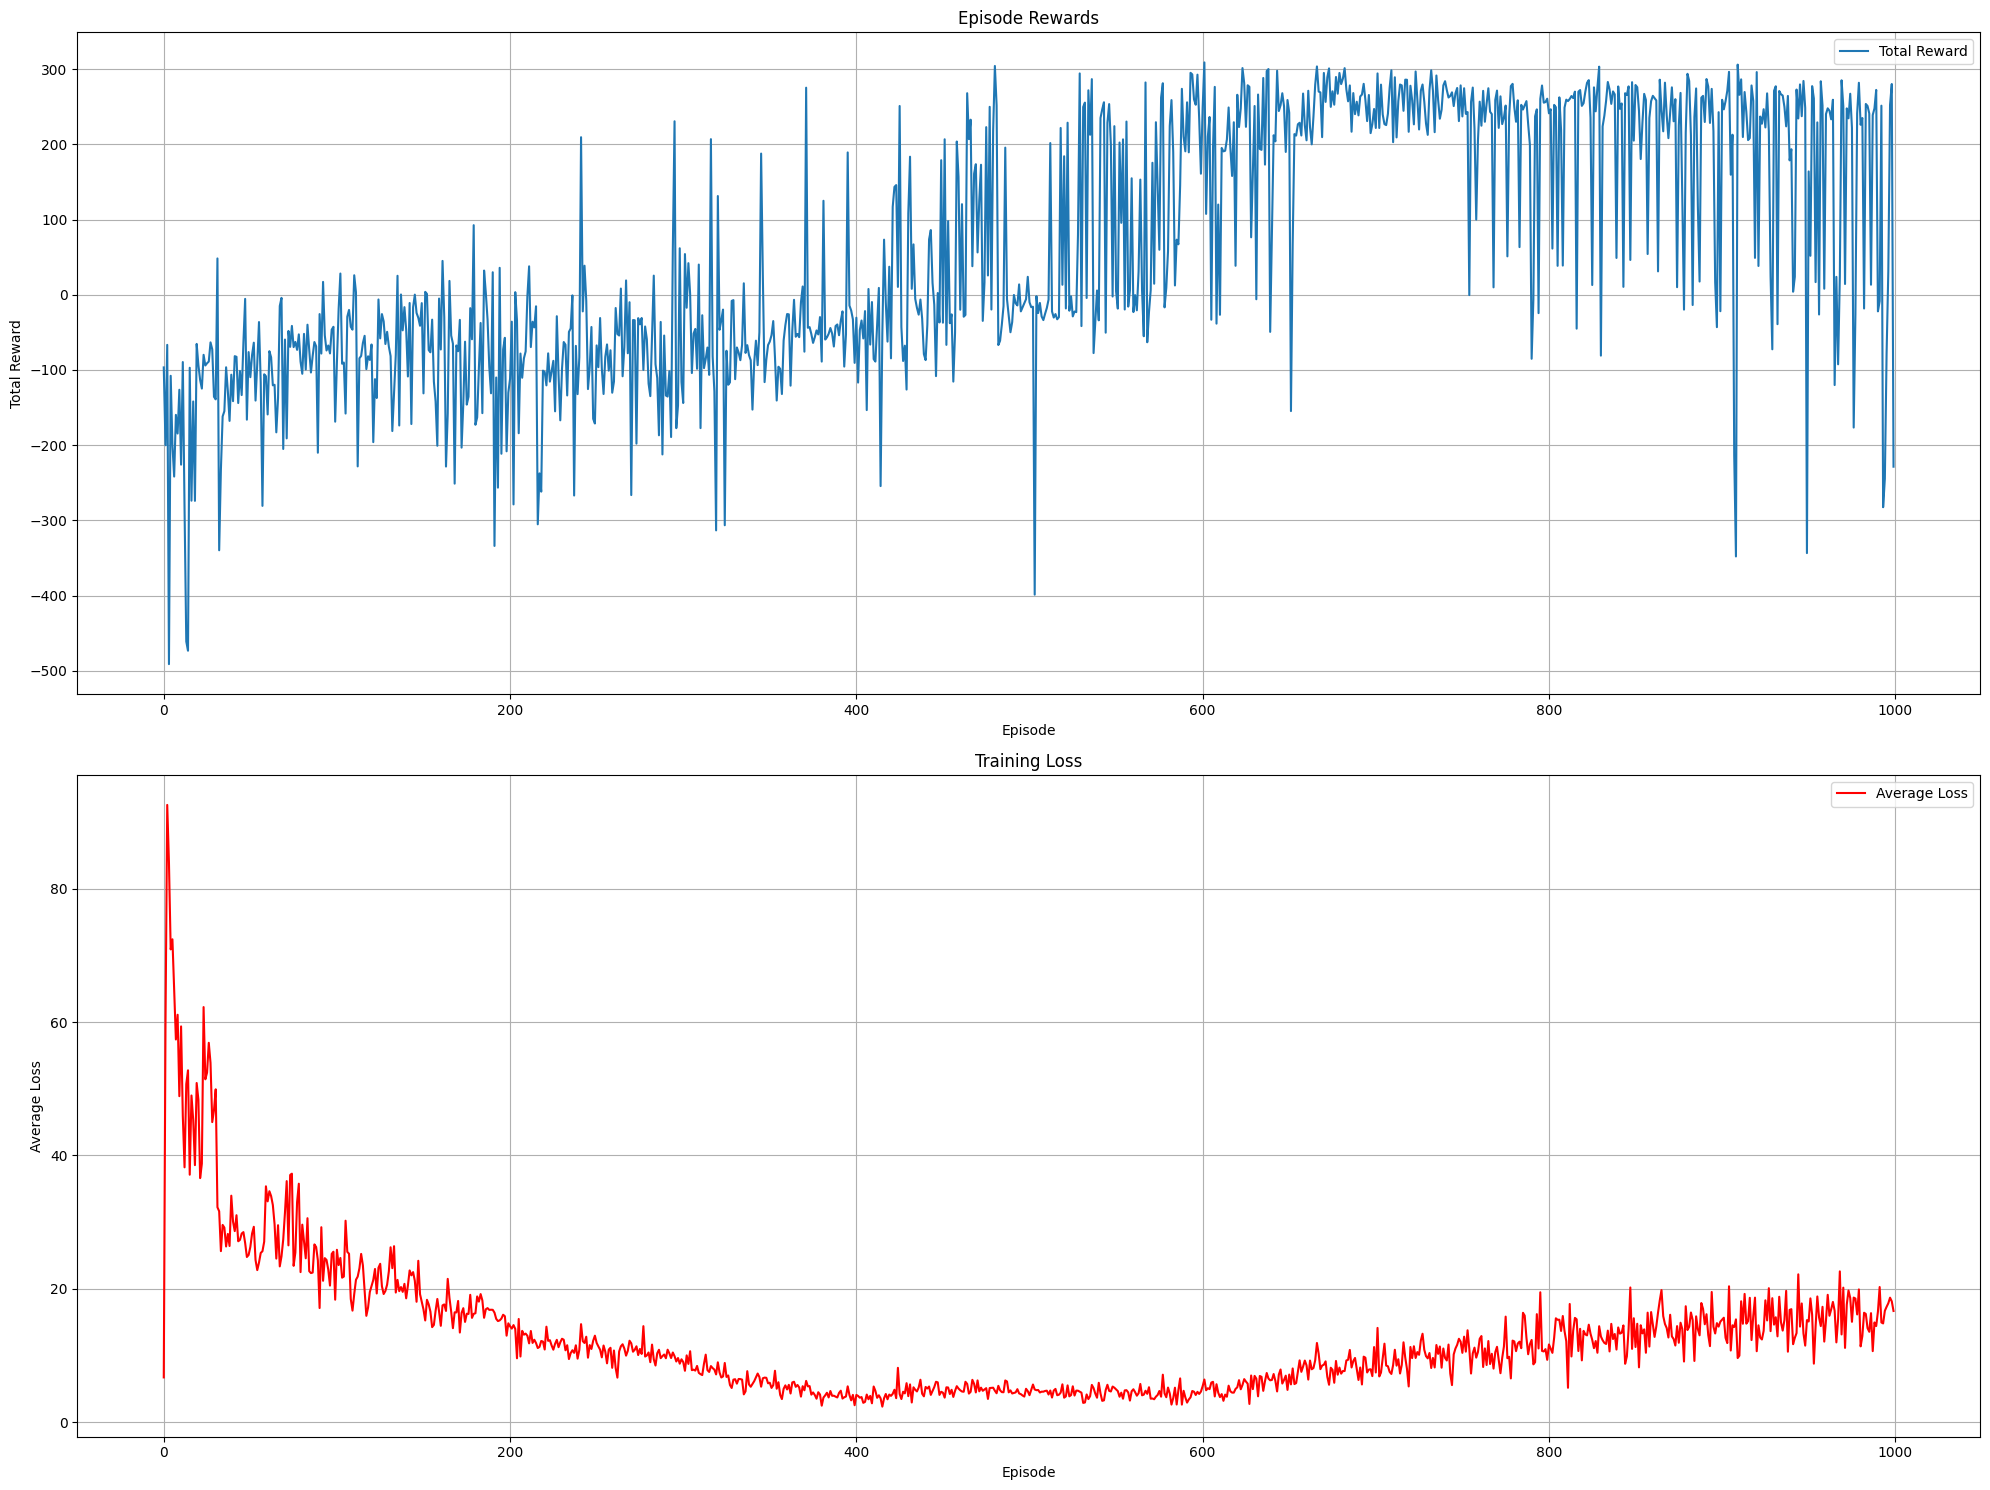

In [12]:
# Plotting results

plt.figure(figsize=(20, 15))  # Taller figure for 2 vertical plots

# Plot 1: Total Rewards per Episode
plt.subplot(2, 1, 1)
plt.plot(rewards_per_episode, label='Total Reward')
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Episode Rewards")
plt.grid(True)
plt.legend()

# Plot 2: Average Training Loss per Episode
plt.subplot(2, 1, 2)
plt.plot(avg_losses, label='Average Loss', color='red')
plt.xlabel("Episode")
plt.ylabel("Average Loss")
plt.title("Training Loss")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# Save model
torch.save(q_net.state_dict(), "dqn_lunar_lander.pth")

In [13]:
# Define the Q-Network (must match training)
class QNetwork(torch.nn.Module):
    def __init__(self, state_dim, action_dim):
        super(QNetwork, self).__init__()
        self.model = torch.nn.Sequential(
            torch.nn.Linear(state_dim, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, action_dim)
        )

    def forward(self, x):
        return self.model(x)

# ----- Settings -----
models_folder = "saved_models"                # Folder where .pth files are saved
output_folder = "videos_batch"                # Output folder for MP4s
os.makedirs(output_folder, exist_ok=True)     # Create folder to store video batch

# Create environment
env = gym.make("LunarLander-v3", render_mode="rgb_array")
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

# Find all model files saved every 100 episodes
model_files = [f for f in os.listdir(models_folder) if f.startswith("dqn_lunar_lander_episode") and f.endswith(".pth")]

# Sort by episode number
model_files = sorted(model_files, key=lambda x: int(x.split("episode")[1].split(".")[0]))  

print(f"Found {len(model_files)} models: {model_files}")

# Loop through each model
for model_file in model_files:
    print(f"Processing {model_file}...")
    
    # Load model
    q_net = QNetwork(state_dim, action_dim)
    model_path = os.path.join(models_folder, model_file)
    q_net.load_state_dict(torch.load(model_path))
    q_net.eval()
    
    # Reset environment and collect frames
    frames = []
    state, _ = env.reset()
    done = False

    while not done:
        with torch.no_grad():
            action = q_net(torch.FloatTensor(state).unsqueeze(0)).argmax().item()
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        frames.append(env.render())
        state = next_state

    # Save GIF
    gif_filename = model_file.replace('.pth', '.gif')
    gif_path = os.path.join(output_folder, gif_filename)
    imageio.mimsave(gif_path, frames, duration=0.03)
    
    print(f"Saved GIF: {gif_path}")

env.close()
print("All GIFs created!")

Found 10 models: ['dqn_lunar_lander_episode100.pth', 'dqn_lunar_lander_episode200.pth', 'dqn_lunar_lander_episode300.pth', 'dqn_lunar_lander_episode400.pth', 'dqn_lunar_lander_episode500.pth', 'dqn_lunar_lander_episode600.pth', 'dqn_lunar_lander_episode700.pth', 'dqn_lunar_lander_episode800.pth', 'dqn_lunar_lander_episode900.pth', 'dqn_lunar_lander_episode1000.pth']
Processing dqn_lunar_lander_episode100.pth...
Saved GIF: videos_batch\dqn_lunar_lander_episode100.gif
Processing dqn_lunar_lander_episode200.pth...
Saved GIF: videos_batch\dqn_lunar_lander_episode200.gif
Processing dqn_lunar_lander_episode300.pth...
Saved GIF: videos_batch\dqn_lunar_lander_episode300.gif
Processing dqn_lunar_lander_episode400.pth...
Saved GIF: videos_batch\dqn_lunar_lander_episode400.gif
Processing dqn_lunar_lander_episode500.pth...
Saved GIF: videos_batch\dqn_lunar_lander_episode500.gif
Processing dqn_lunar_lander_episode600.pth...
Saved GIF: videos_batch\dqn_lunar_lander_episode600.gif
Processing dqn_luna